In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import os
while 'notebooks' in os.getcwd():
    os.chdir("..")

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from datasets import load_dataset
from src.attention_rollout import AttentionRollout
from src.influence import Influence
from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm
from collections import OrderedDict

import seaborn as sns
import numpy as np
import pandas as pd
import wordcloud
from src.text_utils import remove_stopwords, remove_punctuation, get_word_frequencies, lemmatize_text
from copy import deepcopy
from IPython.display import clear_output
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex'])


In [4]:
device = 'cuda'

## AG News

In [5]:
train_dataset = load_dataset("SetFit/ag_news", cache_dir='/Data', split = 'train')\
    .train_test_split(test_size=1000, train_size=2000)

test_dataset = load_dataset("SetFit/ag_news", cache_dir='/Data', split = 'test')

In [6]:
n_classes = len(np.bincount(train_dataset['train']['label']))

In [7]:
label_names = {
    0 : "World",
    1 : "Sports",
    2 : "Business",
    3 : "Sci/Tech"
}

## Limitations of Attention Rollout

In this notebook, based on the paper: Pay Attention to What Matters we will study the difference of norms in the residual connection on attention 

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(
    "peulsilva/bert-ag_news", 
    attn_implementation = 'eager', 
    num_labels = n_classes,
    cache_dir = '/Data'
)\
    .to(device)

tokenizer =AutoTokenizer.from_pretrained("bert-base-uncased")

In [9]:
for name, module in model.named_modules():
    print(name)


bert
bert.embeddings
bert.embeddings.word_embeddings
bert.embeddings.position_embeddings
bert.embeddings.token_type_embeddings
bert.embeddings.LayerNorm
bert.embeddings.dropout
bert.encoder
bert.encoder.layer
bert.encoder.layer.0
bert.encoder.layer.0.attention
bert.encoder.layer.0.attention.self
bert.encoder.layer.0.attention.self.query
bert.encoder.layer.0.attention.self.key
bert.encoder.layer.0.attention.self.value
bert.encoder.layer.0.attention.self.dropout
bert.encoder.layer.0.attention.output
bert.encoder.layer.0.attention.output.dense
bert.encoder.layer.0.attention.output.LayerNorm
bert.encoder.layer.0.attention.output.dropout
bert.encoder.layer.0.intermediate
bert.encoder.layer.0.intermediate.dense
bert.encoder.layer.0.intermediate.intermediate_act_fn
bert.encoder.layer.0.output
bert.encoder.layer.0.output.dense
bert.encoder.layer.0.output.LayerNorm
bert.encoder.layer.0.output.dropout
bert.encoder.layer.1
bert.encoder.layer.1.attention
bert.encoder.layer.1.attention.self
bert.e

In [10]:
import torch
import torch.nn as nn

class HookInputOutput:
    def __init__(self, model):
        """Initialize hooks for all attention layers in the transformer model."""
        self.model = model
        self.hooks = []
        self.inputs = []  # Stores input before attention
        self.outputs = []  # Stores output after attention
        self._register_hooks()
    
    def _hook_fn(self, module, input, output):
        """Hook function to store input and output of attention layers."""
        self.inputs.append(input[0][0].detach().clone().cpu())  # Input before attention
        self.outputs.append(output[0].detach().clone().cpu().squeeze())  # Output after attention
    
    def _register_hooks(self):
        """Finds and registers hooks on all multi-head attention layers."""
        for name, module in self.model.named_modules():
            if name.endswith("attention.self"):
                module.register_forward_hook(self._hook_fn)
    
    def remove_hooks(self):
        """Removes all registered hooks."""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
    
    def get_saved_tensors(self):
        """Returns the stored inputs and outputs."""
        return self.inputs, self.outputs


In [11]:
model._forward_hooks = OrderedDict()

In [12]:
hook = HookInputOutput(model)

In [13]:
train_dataloader = DataLoader(train_dataset['train'], batch_size=1)
val_dataloader = DataLoader(train_dataset['test'], batch_size=1)

In [14]:
for row in tqdm(train_dataloader):
    tokens = tokenizer(
        row['text'], 
        return_tensors='pt',
        padding = 'longest'
    )

    out = model(**tokens.to(device))

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:23<00:00, 86.19it/s]


In [15]:
input_norms = torch.cat(hook.inputs).norm(dim = 1, p= 1)
output_norms = torch.cat(hook.outputs).norm(dim = 1, p =1)

<Figure size 800x500 with 0 Axes>

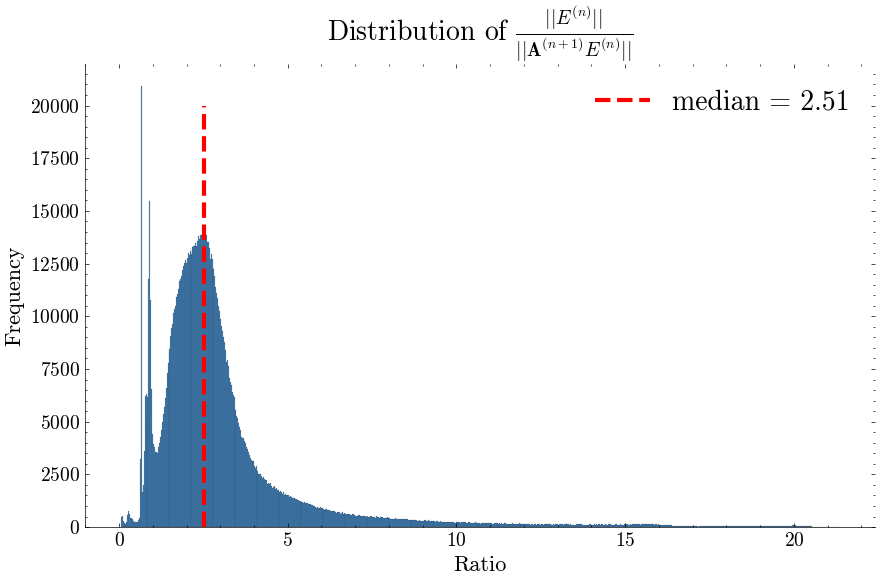

In [17]:

ratio = input_norms / output_norms

# Set figure size
plt.figure(figsize=(8, 5))  # Adjust width and height as needed

# Create the distribution plot
sns.displot(ratio, height=6, aspect=1.5)  # Adjust size within seaborn

# Add vertical median line
plt.vlines(
    ratio.median(),
    0, 
    20_000, 
    colors='red', 
    label=rf"median = {round(ratio.median().item(),2)}",
    linestyles='dashed',
    linewidth = 3
)

# Increase title and label sizes
plt.title(rf"Distribution of $\frac{{ || E^{{(n)}}||}}{{|| \mathbf{{A}}^{{(n+1)}} E^{{(n)}}|| }}$", fontsize=20)
plt.xlabel("Ratio", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.legend(fontsize=20)

# Increase tick label size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


Differently from decoder only architectures, for BERT the norm before and after attention are quite similar

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(
    "peulsilva/bert-ag_news", 
    attn_implementation = 'eager', 
    num_labels = n_classes,
    cache_dir = '/Data'
)\
    .to(device)

tokenizer =AutoTokenizer.from_pretrained("bert-base-uncased")

In [15]:
metric = Influence(model, discard_ratio=0.9)

In [16]:
batch_size = 1

In [19]:
attentions = []
all_tokens = []
all_labels = []
for row in tqdm(train_dataloader):
    tokens = tokenizer(
        row['text'], 
        return_tensors='pt',
        padding = 'longest'
    )

    influence = metric(**tokens.to(device)).unsqueeze(dim = 0)

    for i in range(batch_size):
        try:
            nonzero_idx = (tokens['input_ids'][i] == 0).nonzero()
            if len(nonzero_idx) == 0:
                attentions.append(influence[i])

            else:
                last_idx = nonzero_idx[0].item()
                attentions.append(influence[i, :last_idx, :last_idx])

            all_tokens.append(tokens['input_ids'][i])

            all_labels.append(row['label'][i])
        except:
            pass

  0%|          | 8/2000 [00:00<00:52, 37.80it/s]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000

  1%|          | 13/2000 [00:00<00:50, 39.17it/s]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000,

  1%|          | 21/2000 [00:00<00:56, 35.30it/s]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
       

  2%|▏         | 31/2000 [00:00<00:50, 39.19it/s]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000

  2%|▏         | 35/2000 [00:00<00:51, 38.47it/s]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000,

  2%|▏         | 44/2000 [00:01<00:49, 39.47it/s]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000

  3%|▎         | 54/2000 [00:01<00:48, 40.18it/s]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000

  3%|▎         | 64/2000 [00:01<00:47, 40.94it/s]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
       

  3%|▎         | 68/2000 [00:01<00:49, 38.83it/s]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000

KeyboardInterrupt: 

In [61]:
best_word_dict = []

for i in range(len(all_tokens)):
    topk_indexes = torch.topk(attentions[i][0], k =10).indices[2:]
    best_words = tokenizer.decode(all_tokens[i][topk_indexes])

    best_word_dict.append({
        'words': best_words,
        'label' : all_labels[i].item(),
    })



In [62]:
best_words_per_class = pd.DataFrame(best_word_dict)\
    .groupby('label')\
    .words\
    .sum()

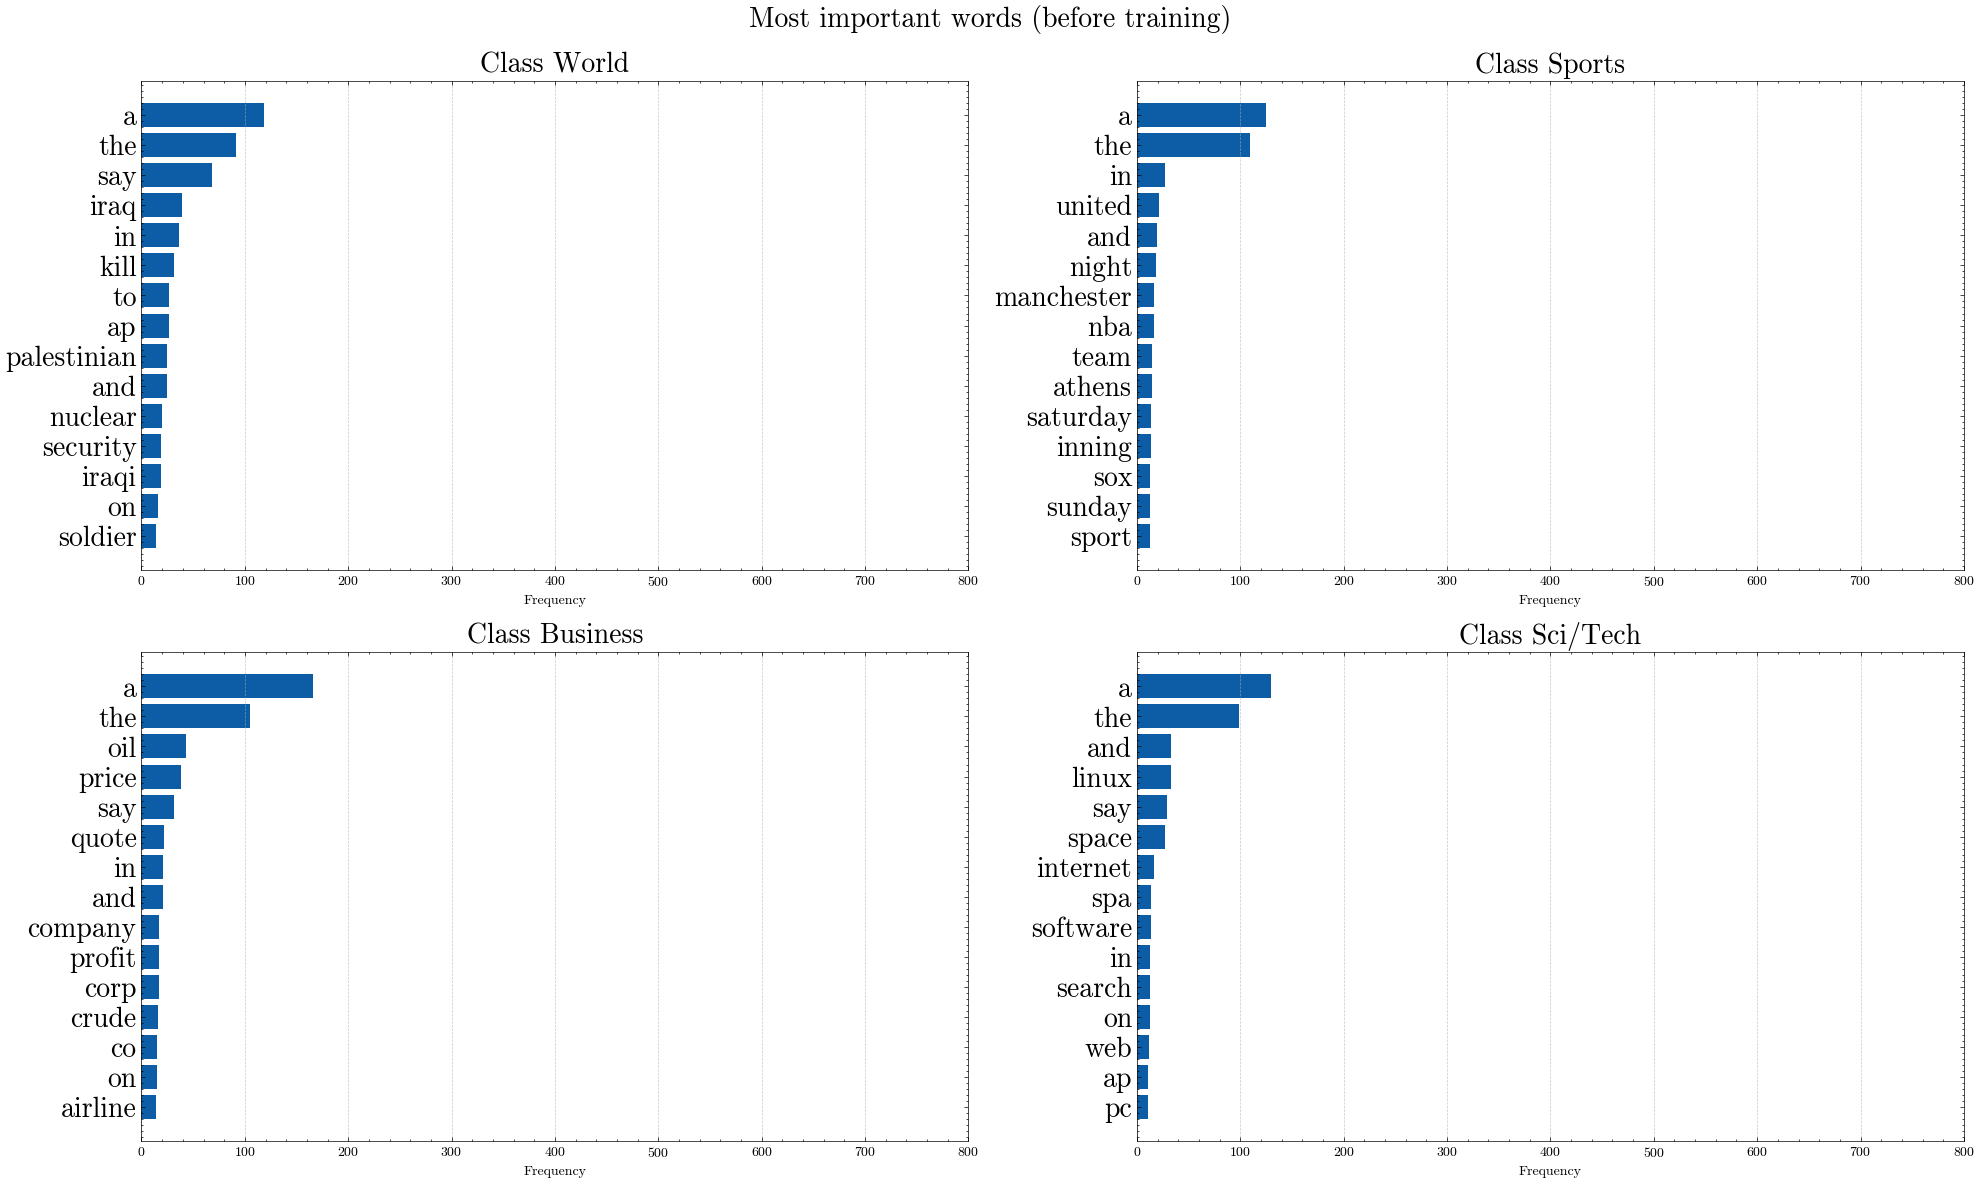

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

for c in range(n_classes):
    most_frequent = lemmatize_text((remove_punctuation(best_words_per_class[c])))
    sorted_frequencies = sorted(get_word_frequencies(most_frequent), key = lambda x: x[1], reverse=True)[0:15]
    
    words, frequencies = zip(*sorted_frequencies)

    # Create the bar plot
    axes[c].barh(words[::-1], frequencies[::-1])  # Reverse order for better visualization
    axes[c].set_xlabel("Frequency")
    axes[c].set_ylabel("")
    axes[c].set_title(f"Class {label_names[c]}", fontsize= 20) 
    axes[c].grid(axis="x", linestyle="--", alpha=0.7)
    axes[c].tick_params(axis='y', labelsize=20)

    axes[c].set_xlim([0, 800])

fig.suptitle("Most important words (before training)", y = 0.99, fontsize = 20)
plt.tight_layout()
plt.show()